# Importing required libraries 

In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, SelectPercentile
from mrmr import mrmr_classif
from sklearn.decomposition import KernelPCA, PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Loading the dataset

In [2]:
# Step 1: Read the dataset using pandas
data = "./Dataset/data.csv"
labels = "./Dataset/labels.csv"

data_df = pd.read_csv(data)
labels_df = pd.read_csv(labels)

original_data_df = data_df.iloc[:, 1:].values
original_labels_df = labels_df.iloc[:, 1:].values

print(original_data_df.shape)
print(original_labels_df.shape)


(801, 20531)
(801, 1)


# Preprocessing: performing up-sampling and normalizing

In [9]:
# Step 2: Perform up-sampling to have a balanced dataset using SMOTE, and using minMax scaler for normalizing

scaler = MinMaxScaler()
data_df = scaler.fit_transform(original_data_df)


smote = SMOTE()
data_df, labels_df = smote.fit_resample(data_df, original_labels_df)

le = LabelEncoder()
labels_df = le.fit_transform(labels_df)


print(data_df.shape)
print(labels_df.shape)       
      

(1500, 20531)
(1500,)


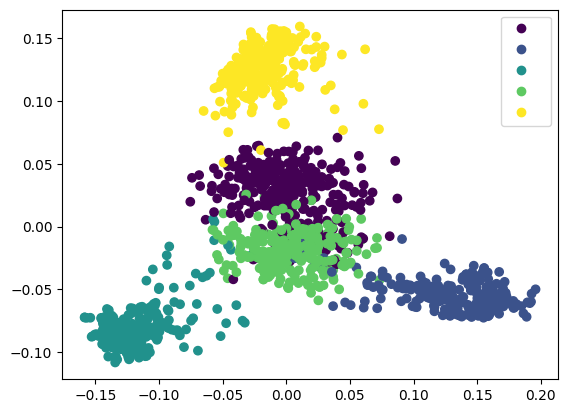

In [10]:
#pca = KernelPCA(data_df)

kpca = KernelPCA(n_components=5, kernel='rbf')
X_kpca_org = kpca.fit_transform(data_df)

plot = plt.scatter(X_kpca_org[:,0], X_kpca_org[:,1], c=labels_df)
plt.legend(handles=plot.legend_elements()[0])
plt.show()

# Performing feature selection: 

- Selecting top 85% features using Chi2
- Selecting Top 100 features using information gain
- Selecting top 25 features using MRMR

In [11]:

# Select top 100 features using mutual information gain
scores = mutual_info_classif(data_df,labels_df)
data_df = SelectKBest(mutual_info_classif, k=100).fit_transform(data_df, labels_df)



In [12]:
# Step 3: Feature selection

# Select top 50% features using chi2
scores = chi2(data_df,labels_df)
data_df = SelectPercentile(chi2, percentile=50).fit_transform(data_df, labels_df)


In [13]:
# Select top 25 features using mRMR
data_df = pd.DataFrame(data_df)

X_new = pd.DataFrame(data_df, columns = data_df.columns)

scores = mrmr_classif(X_new,labels_df,K = 25)

data_df = X_new[scores]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.35it/s]


In [14]:
print('Original number of features:', original_data_df.shape)
print('Reduced number of features:', data_df.shape)

Original number of features: (801, 20531)
Reduced number of features: (1500, 25)


# Dimentionality reduction (K-PCA)

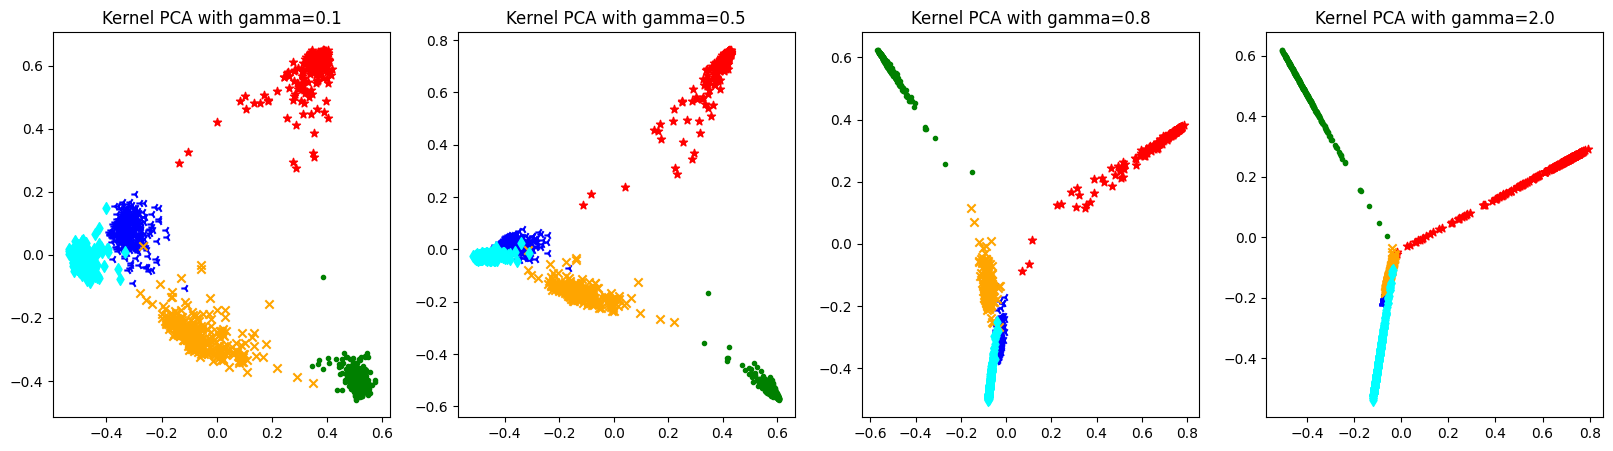

In [33]:
# perform kernel PCA with different gamma values
gammas = [0.15, 0.5, 0.8,2]
fig, axes = plt.subplots(1, len(gammas), figsize=(20, 5))

# define marker styles and colors for each type of points
markers = ['3', '.', '*', 'x', 'd'] # circle and square markers
colors = ['blue', 'green', 'red','orange', 'cyan'] # colors for each type of points

for i, gamma in enumerate(gammas):
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca = kpca.fit_transform(data_df)
    for j, label in enumerate(np.unique(labels_df)):
        mask = labels_df == label
        axes[i].scatter(X_kpca[mask, 0], X_kpca[mask, 1], 
                        c=colors[j], cmap='viridis', 
                        marker=markers[j], label=label)
    axes[i].set_title(f'Kernel PCA with gamma={gamma:.1f}')
    axes[i].legend

plt.show()


In [34]:
# Step 4: Dimensionality reduction using kernel PCA and PCA
kpca = KernelPCA(n_components=5, kernel='rbf', gamma = 0.1)
X_kpca = kpca.fit_transform(data_df)


# Applying Clustering methods on the new dataset


- Applying KMeans on KPCA 

****
- Applying Spectral clustering on KPCA

****
- Applying Expectation Maximization (EM) on KPCA

# Kmeans

In [35]:
# Step 5: Clustering 

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_kpca)
predicted_labels_KPCA = kmeans.labels_


# Step 6: Report accuracy of clustering
accuracy = accuracy_score(labels_df, predicted_labels_KPCA)
print("Accuracy score of Kmeans using KPCA reduction:", accuracy)

Accuracy score of Kmeans using KPCA reduction: 0.202


Text(0.5, 1.0, 'KPCA _ Kmeans')

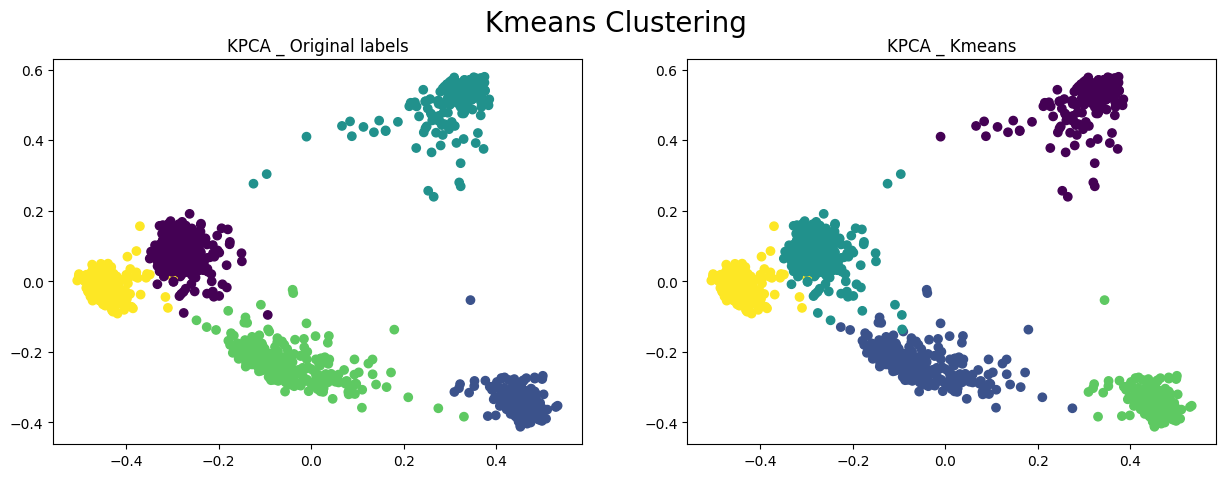

In [36]:
# define marker styles and colors for each type of points

# plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(' Kmeans Clustering ', fontsize=20)

axes[0].scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels_df, cmap='viridis')
axes[0].set_title('KPCA _ Original labels')

axes[1].scatter(X_kpca[:, 0], X_kpca[:, 1], c=predicted_labels_KPCA, cmap='viridis')
axes[1].set_title('KPCA _ Kmeans')


In [37]:
# Evaluate the clustering performance using silhouette score and Calinski-Harabasz index
silhouette = silhouette_score(X_kpca, predicted_labels_KPCA)
ch = calinski_harabasz_score(X_kpca, predicted_labels_KPCA)
print("Accuracy metrics for KPCA _ Kmeans")
print(f"Silhouette score: {silhouette:.3f}")
print(f"Calinski-Harabasz index: {ch:.3f}")


Accuracy metrics for KPCA _ Kmeans
Silhouette score: 0.813
Calinski-Harabasz index: 9670.808


# Spectral Clustering

In [38]:

sc = SpectralClustering(n_clusters=5, affinity='rbf')
predicted_labels_sc = sc.fit_predict(X_kpca)

accuracy_sc = accuracy_score(labels_df, predicted_labels_sc)
print("Accuracy score of Spectral Clustering on original data: {:.2f}".format(accuracy_sc))


Accuracy score of Spectral Clustering on original data: 0.60


Text(0.5, 1.0, 'KPCA _ spectral')

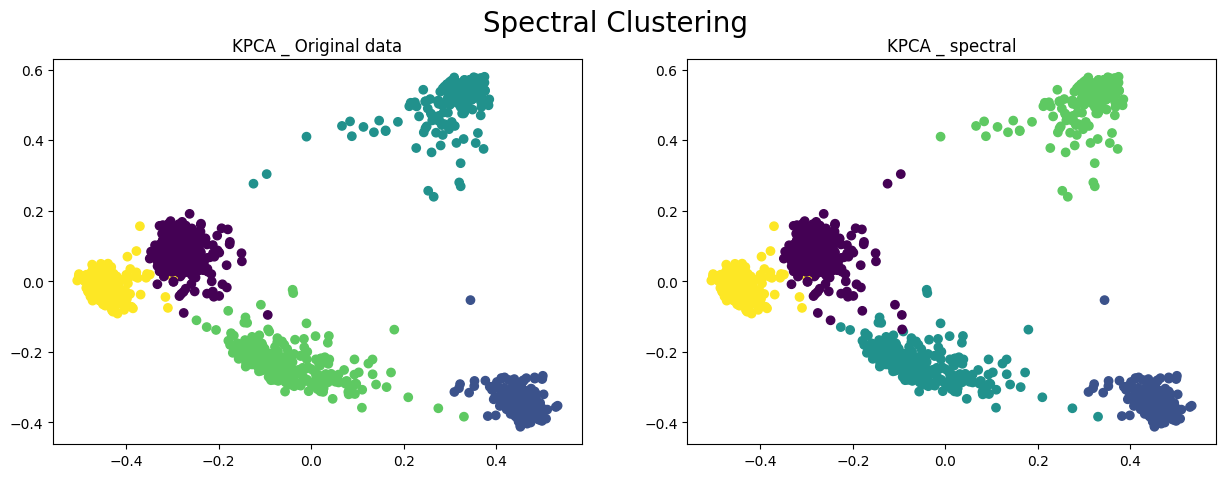

In [39]:
# define marker styles and colors for each type of points

# plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(' Spectral Clustering ', fontsize=20)

axes[0].scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels_df, cmap='viridis')
axes[0].set_title('KPCA _ Original data')


axes[1].scatter(X_kpca[:, 0], X_kpca[:, 1], c=predicted_labels_sc, cmap='viridis')
axes[1].set_title('KPCA _ spectral')

In [40]:
# Evaluate the clustering performance using silhouette score and Calinski-Harabasz index
silhouette = silhouette_score(X_kpca, predicted_labels_sc)
ch = calinski_harabasz_score(X_kpca, predicted_labels_sc)
print("Accuracy metrics for KPCA _ Spectral Clustering")
print(f"Silhouette score: {silhouette:.3f}")
print(f"Calinski-Harabasz index: {ch:.3f}")


Accuracy metrics for KPCA _ Spectral Clustering
Silhouette score: 0.813
Calinski-Harabasz index: 9643.152


# Expectation and maximization (GMM)

In [41]:

em = GaussianMixture(n_components=5)
predicted_labels_em = em.fit_predict(X_kpca)

accuracy_em = accuracy_score(labels_df, predicted_labels_em)
print("Accuracy score: {:.2f}".format(accuracy_em))

Accuracy score: 0.00


Text(0.5, 1.0, 'KPCA _ predicted')

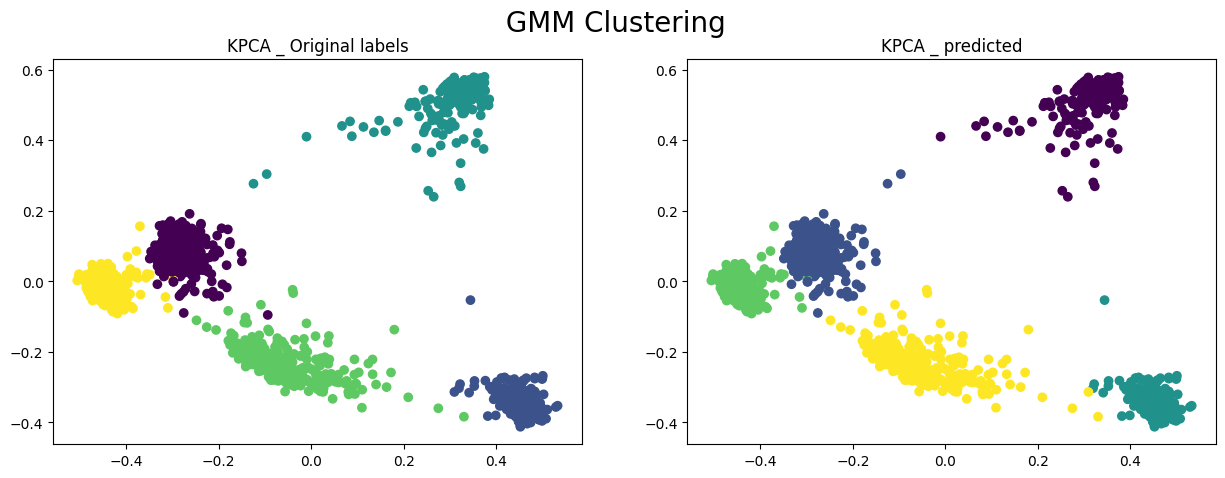

In [42]:
# define marker styles and colors for each type of points

# plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(' GMM Clustering ', fontsize=20)


axes[0].scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels_df, cmap='viridis')
axes[0].set_title('KPCA _ Original labels')


axes[1].scatter(X_kpca[:, 0], X_kpca[:, 1], c=predicted_labels_em, cmap='viridis')
axes[1].set_title('KPCA _ predicted')

In [43]:
# Evaluate the clustering performance using silhouette score and Calinski-Harabasz index
silhouette = silhouette_score(X_kpca, predicted_labels_em)
ch = calinski_harabasz_score(X_kpca, predicted_labels_em)
print("Accuracy metrics for KPCA _ GMM Clustering")
print(f"Silhouette score: {silhouette:.3f}")
print(f"Calinski-Harabasz index: {ch:.3f}")

Accuracy metrics for KPCA _ GMM Clustering
Silhouette score: 0.810
Calinski-Harabasz index: 9352.174
